# Cortical and subcortical activity in a visual discrimination task from mice
source: Steinmetz database from https://compneuro.neuromatch.io/projects/neurons/README.html

### About the data
Description form the Neuromatch website: *The Steinmetz dataset (youtube) contains 39 Neuropixels recordings of 400-700 neurons each from across the mouse brain during a visual behavior task. This dataset is great for exploratory analyses and is relatively well supported with code and included many experimental and behavioral variables. You should still try to ask specific questions, i.e.: “does the superior colliculus offer a parallel or complementary visual processing pathway to visual cortex?”*

Credit for data curation: Marius Pachitariu, Scott Linderman

- Steinmetz, N. A., Zatka-Haas, P., Carandini, M., and Harris, K. D. (2019). Distributed coding of choice, action and engagement across the mouse brain. Nature, 576(7786): 266-273. doi: 10.1038/s41586-019-1787-x https://www.nature.com/articles/s41586-019-1787-x

### Load some useful libraries

*numpy* - to work with arrays (https://numpy.org/), *matplotlib* - to create simple plots (https://matplotlib.org/), *scipy.interpolate* to convert from time to position (https://docs.scipy.org/doc/scipy/reference/interpolate.html)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
import os, requests

%matplotlib widget

import scipy.sparse as sps
# from pyglmnet import GLM, simulate_glm

### 1. Retrieving and loading the data

In [2]:
# Data retrieval - only needed once

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [3]:
# Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('datasets/Steinmetz/steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

alldat contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each dat = alldat[k], you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

    dat['mouse_name']: mouse name
    dat['date_exp']: when a session was performed
    dat['spks']: neurons by trials by time bins.
    dat['brain_area']: brain area for each neuron recorded.
    dat['ccf']: Allen Institute brain atlas coordinates for each neuron.
    dat['ccf_axes']: axes names for the Allen CCF.
    dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
    dat['contrast_left']: contrast level for left stimulus.
    dat['gocue']: when the go cue sound was played.
    dat['response_time']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.
    dat['response']: which side the response was (-1, 0, 1). When the right-side stimulus had higher contrast, the correct choice was -1. 0 is a no go response.
    dat['feedback_time']: when feedback was provided.
    dat['feedback_type']: if the feedback was positive (+1, reward) or negative (-1, white noise burst).
    dat['wheel']: turning speed of the wheel that the mice uses to make a response, sampled at 10ms.
    dat['pupil']: pupil area (noisy, because pupil is very small) + pupil horizontal and vertical position.
    dat['face']: average face motion energy from a video camera.
    dat['licks']: lick detections, 0 or 1.
    dat['trough_to_peak']: measures the width of the action potential waveform for each neuron. Widths <=10 samples are "putative fast spiking neurons".
    dat['%X%_passive']: same as above for X = {spks, pupil, wheel, contrast_left, contrast_right} but for passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
    dat['prev_reward']: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
    dat['reaction_time']: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above 5 ticks/10ms bin. Second column: direction of the wheel movement (0 = no move detected).

The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406


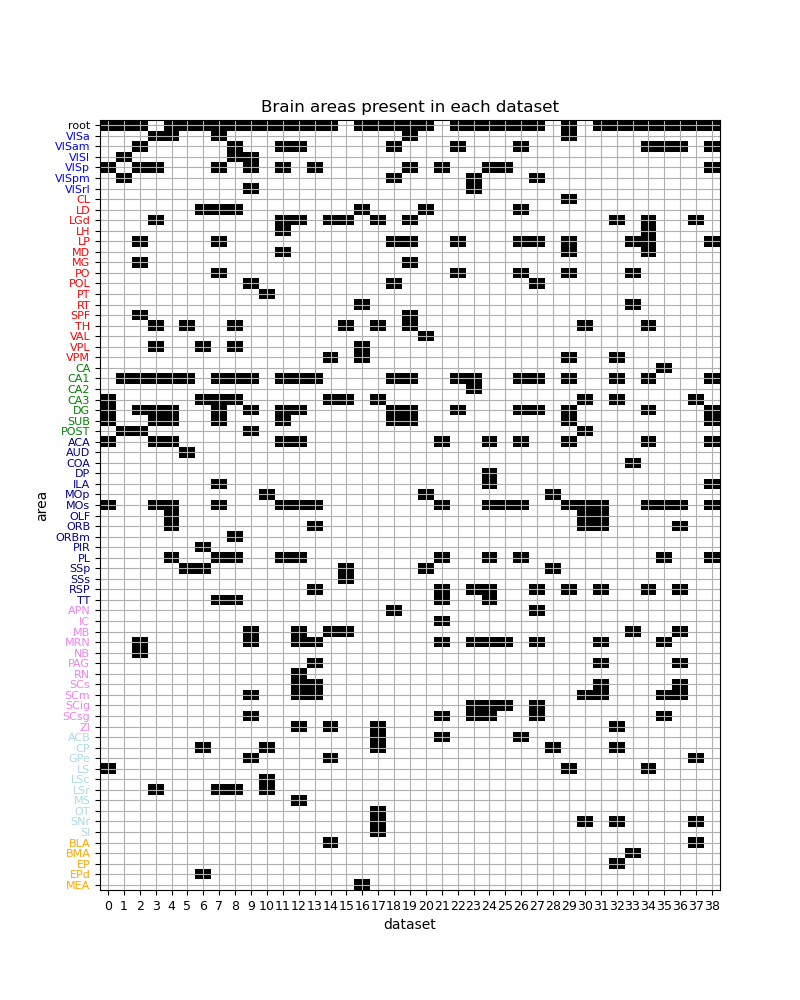

In [4]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
# plt.savefig('datasets/Steinmetz/brain_regions.pdf')

### Basic plots of population average

In [5]:
# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11] ## neurons by trials by time bins.
print(dat.keys())


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


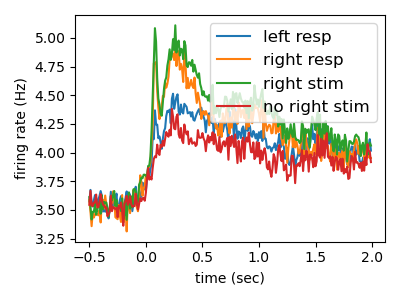

In [6]:
dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

fig, ax = plt.subplots(figsize=(4,3))
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
ax.plot(dt * np.arange(NT)-0.5, 1/dt * dat['spks'][:, response >= 0].mean(axis=(0, 1)))  # left responses
ax.plot(dt * np.arange(NT)-0.5, 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
ax.plot(dt * np.arange(NT)-0.5, 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
ax.plot(dt * np.arange(NT)-0.5, 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

ax.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
fig.tight_layout()
# plt.savefig('datasets/Steinmetz/ave_stim_resp.pdf')

In [7]:
dat['spks'].shape

(698, 340, 250)

## plots by brain region and visual conditions

In [8]:
nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

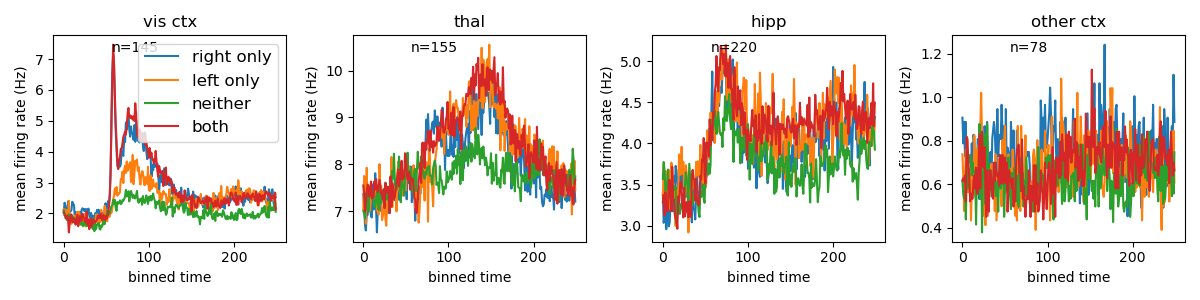

In [9]:
fig, axs = plt.subplots(1, nareas, figsize=(12, 3), sharey=False)

for j in range(nareas):
  axs[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  axs[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  axs[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  axs[j].plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  axs[j].text(.25, .92, 'n=%d'%np.sum(barea == j), transform=axs[j].transAxes)

  if j==0:
    axs[j].legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  axs[j].set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=regions[j])
plt.tight_layout()
# plt.savefig('datasets/Steinmetz/resp_areas.pdf')

## plots by brain region and response type

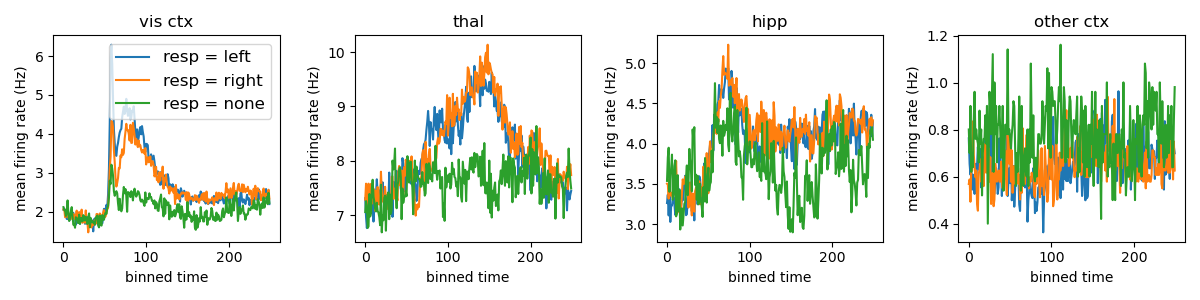

In [10]:
fig, axs = plt.subplots(1, nareas, figsize=(12, 3), sharey=False)

for j in range(nareas):
  axs[j].plot(1/dt * dat['spks'][barea == j][:, response < 0].mean(axis=(0, 1)))
  axs[j].plot(1/dt * dat['spks'][barea == j][:, response > 0].mean(axis=(0, 1)))
  axs[j].plot(1/dt * dat['spks'][barea == j][:, response == 0].mean(axis=(0, 1)))

  if j==0:
    axs[j].legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  axs[j].set(xlabel='binned time', ylabel='mean firing rate (Hz)', title=regions[j])
plt.tight_layout()
# plt.savefig('datasets/Steinmetz/resp_areas_resp.pdf')

# Contrast tuning

In [10]:
i_visual = np.flatnonzero(dat['brain_area'] == 'VISp')

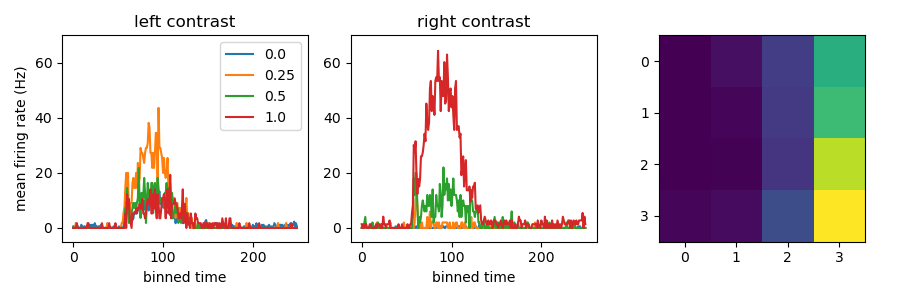

In [11]:
# neurons by trials by time bins.
dat_vis = dat['spks'][i_visual,:,:] ## 66 x 340 x 250
contrast_levels = np.unique(dat['contrast_left'])

# for i_cell in np.arange(N_cells) 2
i_cell = 34

meanresp = np.zeros((4,4))

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=False)
for i_level in np.arange(4):
    c_left = dat['contrast_left'] == contrast_levels[i_level]
    c_right = dat['contrast_right'] == contrast_levels[i_level]
    axs[0].plot(1/dt * dat_vis[i_cell, c_left,:].mean(axis=0), label=str(contrast_levels[i_level]))
    axs[1].plot(1/dt * dat_vis[i_cell, c_right,:].mean(axis=0))

for i_level_left in np.arange(4):
    for i_level_right in np.arange(4):
        c_left_right = np.logical_and(dat['contrast_left'] == contrast_levels[i_level_left], dat['contrast_right'] == contrast_levels[i_level_right])
        meanresp[i_level_left, i_level_right] = np.mean(np.sum(dat_vis[i_cell, c_left_right,:], axis=1))


axs[2].imshow((meanresp))

axs[0].legend()
axs[0].set(xlabel='binned time', ylabel='mean firing rate (Hz)', title='left contrast', ylim=(-5, 70))
axs[1].set(xlabel='binned time', title='right contrast', ylim=(-5, 70))  
fig.tight_layout()

In [12]:
dat['contrast_left'] == contrast_levels[i_level_left]

array([False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,

In [55]:
np.sum(dat_vis[i_cell, c_left,:], axis=1)

array([ 0,  0,  3,  0,  0,  0,  6,  3,  4, 39,  0,  0,  0,  0,  0,  0,  0,
        0, 27,  0,  1,  0,  0, 40,  1,  0,  2, 20,  4,  2,  2,  4, 36,  4,
        0,  0,  8,  2,  1,  4,  0,  2, 22,  0, 42,  1,  0,  0,  0,  1, 34,
        1,  4,  0,  6,  7,  5])

In [65]:
dt

0.01